# Getting Started

## Ensemble models (2)

> (tutorial) https://juliaai.github.io/DataScienceTutorials.jl/getting-started/ensembles-2/
> <br> (projcet folder) https://raw.githubusercontent.com/juliaai/DataScienceTutorials.jl/gh-pages/__generated/A-ensembles-2.tar.gz

In [1]:
using Pkg; Pkg.activate("D:/JULIA/6_ML_with_Julia/A-ensembles-2"); Pkg.instantiate()

  Activating project at `D:\JULIA\6_ML_with_Julia\A-ensembles-2`


> Prelims <br>
> Random forest
> 1. Tuning
> 2. Reporting

### Prelims

---

This tutorial builds upon the previous ensemble tutorial with a **home-made Random Forest regressor** on the "boston" dataset.

In [2]:
using MLJ
using PyPlot
using PrettyPrinting
using StableRNGs
import DataFrames: DataFrame, describe

X, y = @load_boston
sch = schema(X)
p = length(sch.names)
describe(y) # From DataFrames

Summary Stats:
Length:         506
Missing Count:  0
Mean:           22.532806
Minimum:        5.000000
1st Quartile:   17.025000
Median:         21.200000
3rd Quartile:   25.000000
Maximum:        50.000000
Type:           Float64


Let's load the decision tree regressor

In [3]:
DecisionTreeRegressor = @load DecisionTreeRegressor pkg = DecisionTree

import MLJDecisionTreeInterface ✔


┌ Info: For silent loading, specify `verbosity=0`. 
└ @ Main C:\Users\jeffr\.julia\packages\MLJModels\tMgLW\src\loading.jl:168


MLJDecisionTreeInterface.DecisionTreeRegressor

Let's first check the performances of just a single Decision Tree Regressor (DTR for shot):

In [4]:
tree = machine(DecisionTreeRegressor(), X, y)
e = evaluate!(tree, resampling = Holdout(fraction_train = 0.8), measure = [rms, rmslp1])
e

PerformanceEvaluation object with these fields:
  measure, measurement, operation, per_fold,
  per_observation, fitted_params_per_fold,
  report_per_fold, train_test_pairs
Extract:
┌───────────────────────────────────────────────────┬─────────────┬─────────────
│ measure                                           │ measurement │ operation  ⋯
├───────────────────────────────────────────────────┼─────────────┼─────────────
│ RootMeanSquaredError()                            │ 7.05        │ predict    ⋯
│ RootMeanSquaredLogProportionalError(offset = 1.0) │ 0.327       │ predict    ⋯
└───────────────────────────────────────────────────┴─────────────┴─────────────
                                                                1 column omitted


Note that multiple measures can be reported simultaneously.

### Random forest

---

Let's create an ensemble of DTR and fix the number of subfeatures to 3 for now.

In [5]:
forest = EnsembleModel(model = DecisionTreeRegressor())
forest.model.n_subfeatures = 3

3

(Nota Bene: we could have fixed ```n_subfeatures``` in the DTR constructors too).

To get an idea of how many trees are needed, we can follow the evaluation of the error (say the ```rms```) for an increasing number of tree over several sampling round.

In [6]:
rng = StableRNG(5123) # for reporducibility
m = machine(forest, X, y)
r = range(forest, :n, lower = 10, upper = 1000)
curves = learning_curve!(m, 
                        resampling = Holdout(fraction_train = 0.8, rng = rng),
                        range = r, 
                        measure = rms)

┌ Info: Training Machine{DeterministicTunedModel{Grid,…},…}.
└ @ MLJBase C:\Users\jeffr\.julia\packages\MLJBase\MuLnJ\src\machines.jl:464
┌ Info: Attempting to evaluate 30 models.
└ @ MLJTuning C:\Users\jeffr\.julia\packages\MLJTuning\Al9yX\src\tuned_models.jl:680
Evaluating over 30 metamodels: 100%[=========================] Time: 0:00:20


(parameter_name = "n",
 parameter_scale = :linear,
 parameter_values = [10, 44, 78, 112, 147, 181, 215, 249, 283, 317  …  693, 727, 761, 795, 829, 863, 898, 932, 966, 1000],
 measurements = [3.3415585467177604, 3.0965990239920864, 3.0904102919885448, 3.1204995519316134, 3.1359716181984005, 3.1454382664588465, 3.1158230496511816, 3.1001639206786407, 3.102237185310257, 3.098269300659861  …  3.0540776134038157, 3.0475941834202547, 3.0461048370218133, 3.0438702110593634, 3.041516871191065, 3.042017618230169, 3.0458905162517844, 3.0501713697389037, 3.0497463894574137, 3.047772615469327],)

let's plot the curves

┌ Warning: `vendor()` is deprecated, use `BLAS.get_config()` and inspect the output instead
│   caller = npyinitialize() at numpy.jl:67
└ @ PyCall C:\Users\jeffr\.julia\packages\PyCall\L0fLP\src\numpy.jl:67


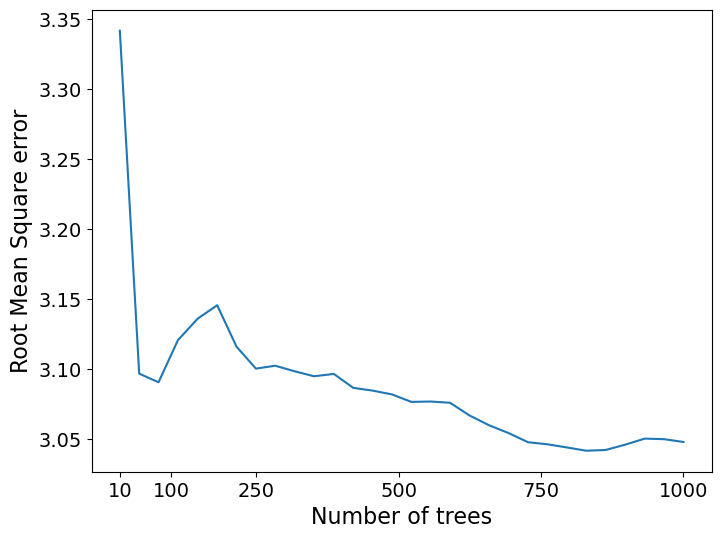

In [7]:
figure(figsize = (8, 6))
plot(curves.parameter_values, curves.measurements)
ylabel("Root Mean Square error", fontsize = 16)
xlabel("Number of trees", fontsize = 16)
xticks([10, 100, 250, 500, 750, 1000], fontsize = 14)
yticks(fontsize =  14)
savefig("./plots/2.5.1.png")

Let's go for 150  trees

In [8]:
forest.n = 150;

### Tunig

As ```forest``` is a composite model, it has nested hyperparameters;

In [9]:
params(forest) |> pprint

(model = (max_depth = -1,
          min_samples_leaf = 5,
          min_samples_split = 2,
          min_purity_increase = 0.0,
          n_subfeatures = 3,
          post_prune = false,
          merge_purity_threshold = 1.0,
          rng = Random._GLOBAL_RNG()),
 atomic_weights = [],
 bagging_fraction = 0.8,
 rng = Random._GLOBAL_RNG(),
 n = 150,
 acceleration = CPU1{Nothing}(nothing),
 out_of_bag_measure = [])

Let's define a range for the number of subfeatures and for the bagging fractions:

In [10]:
r_sf = range(forest, :(model.n_subfeatures), lower = 1, upper = 12)
r_bf = range(forest, :bagging_fraction, lower = 0.4, upper = 1.0)

NumericRange(0.4 ≤ bagging_fraction ≤ 1.0; origin=0.7, unit=0.3)

And build a tuned model as usual that we fit on a 80/20 split. We use a low-resolution grid here to make this tutorial faster but you could of course use a finer grid.

In [11]:
tuned_forest = TunedModel(model = forest, 
                          tuning = Grid(resolution = 3),
                          resampling = CV(nfolds = 6, rng = StableRNG(32)),
                          ranges = [r_sf, r_bf],
                          measure = rms)

m = machine(tuned_forest, X, y)
e = evaluate!(m, 
              resampling = Holdout(fraction_train = 0.8),
              measure = [rms, rmslp1])
e

PerformanceEvaluation object with these fields:
  measure, measurement, operation, per_fold,
  per_observation, fitted_params_per_fold,
  report_per_fold, train_test_pairs
Extract:
┌───────────────────────────────────────────────────┬─────────────┬─────────────
│ measure                                           │ measurement │ operation  ⋯
├───────────────────────────────────────────────────┼─────────────┼─────────────
│ RootMeanSquaredError()                            │ 3.97        │ predict    ⋯
│ RootMeanSquaredLogProportionalError(offset = 1.0) │ 0.253       │ predict    ⋯
└───────────────────────────────────────────────────┴─────────────┴─────────────
                                                                1 column omitted


In [12]:
best_forest = fitted_params(m).best_model

DeterministicEnsembleModel(
    model = DecisionTreeRegressor(
            max_depth = -1,
            min_samples_leaf = 5,
            min_samples_split = 2,
            min_purity_increase = 0.0,
            n_subfeatures = 6,
            post_prune = false,
            merge_purity_threshold = 1.0,
            rng = Random._GLOBAL_RNG()),
    atomic_weights = Float64[],
    bagging_fraction = 1.0,
    rng = Random._GLOBAL_RNG(),
    n = 150,
    acceleration = CPU1{Nothing}(nothing),
    out_of_bag_measure = Any[])

### Reporting

Again, you could show a 2D heatmap of the hyperparameters

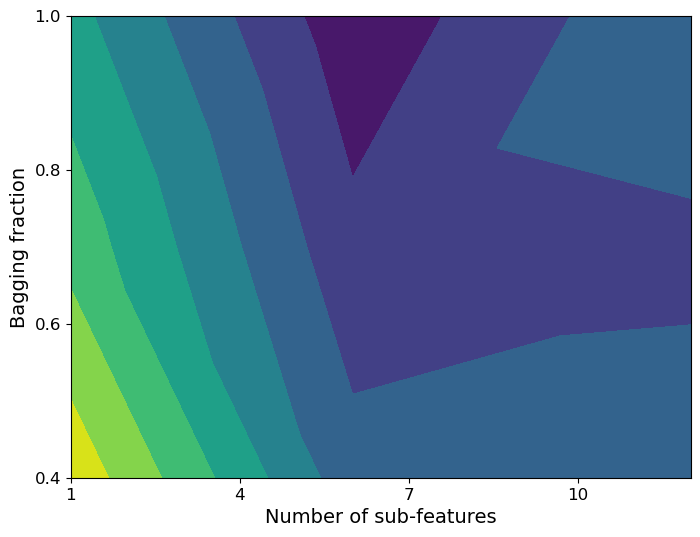

In [13]:
r = report(m)

figure(figsize=(8,6))

res = r.plotting

vals_sf = res.parameter_values[:, 1]
vals_bf = res.parameter_values[:, 2]

tricontourf(vals_sf, vals_bf, res.measurements)
xticks(1:3:12, fontsize = 12)
xlabel("Number of sub-features", fontsize = 14)
yticks(0.4:0.2:1, fontsize = 12)
ylabel("Bagging fraction", fontsize = 14)
savefig("./plots/2.5.2.png")

Even though we've only done a very rough search, it seems that around 7 sub-features and a bagging fraction of around ```0.75``` work well.

Now that the machine ```m``` is trained, you can use it for predictions (implicitly, this will use the best model). For instance we could look at predictions on the whole dataset:

In [14]:
best_forest.bagging_fraction

1.0

In [15]:
best_forest.model.n_subfeatures

6

In [16]:
ŷ = predict(m, X)
@show rms(ŷ, y)

rms(ŷ, y) = 2.3912899953185565


2.3912899953185565